<a href="https://colab.research.google.com/github/HyberionBrew/PaperImplementations/blob/main/Case_based_reasoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an implementation of the paper [Deep Learning for Case-Based Reasoning through Prototypes:
A Neural Network that Explains Its Predictions](https://arxiv.org/pdf/1710.04806.pdf).

In [1]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts
! pip install wandb
! pip install optuna

In [2]:
import torch
import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger
import torchvision
from torchvision import transforms
import os
from torch.utils.data import DataLoader, random_split
import pl_bolts
#from pl_bolts.transforms.dataset_normalizations import emnist_normalization
AVAIL_GPUS = min(1, torch.cuda.device_count())

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
from torchvision.datasets import MNIST


PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")


transformations = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize(0.173, 0.332),
    ]
)
BATCH_SIZE = 128

train_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transformations)
test_ds = MNIST(PATH_DATASETS, train=False, download=True, transform=transformations)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [5]:
from torch import nn
print(next(iter(train_loader))[0].shape)

torch.Size([128, 1, 28, 28])


In [6]:
# Encodes into latenspace
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # downsample
        self.Conv = nn.Sequential(
            nn.Conv2d(1,32,3,stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(), # replace with sigmoid? Why?
            nn.Conv2d(32,32,3,stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(), # replace with sigmoid? Why?
            nn.Conv2d(32,32,3,stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(), # might want to replace
            nn.Conv2d(32,10,3,stride=2, padding=1),
            nn.LazyBatchNorm2d(), # not in paper
            nn.Flatten()
        )

    def forward(self, ins):
        x = self.Conv(ins)
        output = torch.sigmoid(x)
        return output
        
    @property
    def device(self):
        return next(self.parameters()).device

In [7]:
from torchsummary import summary
print(next(iter(train_loader))[0][1].shape)
print(next(iter(train_loader))[0].shape)
summary(Encoder(), next(iter(train_loader))[0][1].shape,device='cpu')

torch.Size([1, 28, 28])
torch.Size([128, 1, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           9,248
       BatchNorm2d-5             [-1, 32, 7, 7]              64
              ReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
       BatchNorm2d-8             [-1, 32, 4, 4]              64
              ReLU-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 10, 2, 2]           2,890
      BatchNorm2d-11             [-1, 10, 2, 2]              20
          Flatten-12                   [-1, 40]               0
Total params: 21,918
Trainable params: 21,918
Non-

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
# Decodes from latenspace
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # downsample
        self.TransConv = nn.Sequential(
            nn.ConvTranspose2d(10,32,3, stride=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.ConvTranspose2d(32,32,3,stride=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(), # replace with sigmoid? Why?
            nn.ConvTranspose2d(32,32,3,stride=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(), # might want to replace
            nn.ConvTranspose2d(32,1,3,stride=3, padding=1),
            nn.LazyBatchNorm2d(), # not in paper
        )

    def forward(self, x):
        x = x.view(-1,10,2,2)
        x = self.TransConv(x)
        output = torch.sigmoid(x)
        return output
        
    @property
    def device(self):
        return next(self.parameters()).device

In [9]:
z = Encoder()(next(iter(train_loader))[0])
print(z[0].shape)
summary(Decoder(), z[0].shape,device='cpu')

torch.Size([40])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 32, 2, 2]           2,912
       BatchNorm2d-2             [-1, 32, 2, 2]              64
              ReLU-3             [-1, 32, 2, 2]               0
   ConvTranspose2d-4             [-1, 32, 4, 4]           9,248
       BatchNorm2d-5             [-1, 32, 4, 4]              64
              ReLU-6             [-1, 32, 4, 4]               0
   ConvTranspose2d-7           [-1, 32, 10, 10]           9,248
       BatchNorm2d-8           [-1, 32, 10, 10]              64
              ReLU-9           [-1, 32, 10, 10]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             289
      BatchNorm2d-11            [-1, 1, 28, 28]               2
Total params: 21,891
Trainable params: 21,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Encoder-Decoder training test

In [10]:
class Autoencoder(pl.LightningModule):
    def __init__(self, lr=0.0001):

        super().__init__()
        self.Decoder = Decoder()
        self.Encoder = Encoder()
        self.mse_loss = nn.MSELoss()
        self.learning_rate = lr

    def forward(self, x):
        z = self.Encoder(x)
        out = self.Decoder(z)
        return out

    def training_step(self, batch, batch_idx):
        x,y = batch
        out_image = self(x)
        loss = self.mse_loss(out_image, x)
        self.log("traing_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x,y = batch
        out_image = self(x)
        loss = self.mse_loss(out_image, x)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [11]:
wandb.login()

wandb: Currently logged in as: kressef (skylab). Use `wandb login --relogin` to force relogin


True

In [29]:
run = wandb.init(project="Case-based-Reasoning", entity="kressef", reinit=True)
model = Autoencoder()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [30]:
wandb_logger = WandbLogger()
pl.Trainer()
trainer = pl.Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=2,
    progress_bar_refresh_rate=20,
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=10,   # set the logging frequency
)
trainer.fit(model,train_dataloaders=train_loader,val_dataloaders=test_loader)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUse

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [31]:
run.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
traing_loss,█▅▅▅▄▃▃▃▃▃▂▃▃▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,█▁
epoch,1
trainer/global_step,1875
traing_loss,0.86916
val_loss,0.8773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


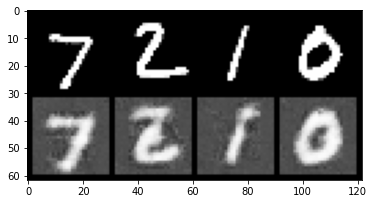

In [32]:
import matplotlib.pyplot as plt
ins, _ = next(iter(test_loader))
ins = ins[0:4]
outs = model(ins)
grid_img = torchvision.utils.make_grid(torch.cat((ins,outs)), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

#Add prototypes and prediction loss

In [32]:
# Encodes into latenspace
import torch.nn.functional as F
class PrototypeNetwork(nn.Module):
    def __init__(self, prot_nodes=20, z_dim=40, out_dim=10):
        super().__init__()
        # downsample
        #test = torch.ones(prot_nodes,z_dim)
        #test[1,:] = test[1,:] - 0.5
        #test[2,:] = test[2,:] - 1
        self.prototype_layer= torch.nn.Parameter(torch.rand((prot_nodes,z_dim)))

        self.p = prot_nodes
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(prot_nodes,out_dim, bias=False)
        self.z_dim = z_dim

    # should vectorize the for loops in this function
    def forward(self, ins):
        # apply prototype_layer
        #print(ins.shape)
        
        ins = torch.unsqueeze(ins,1)
        m = torch.Tensor().to(self.device)
        # to each in batch, replace with vec comp
        for i in range(ins.shape[0]):
            xx = torch.norm((ins[i].expand(self.p,-1) - self.prototype_layer),dim=1).unsqueeze(0) #.unsqueeze(0)**2
            #print(xx.shape)
            m = torch.cat((m,xx),0)
            #print(m)
        #print(m.shape)
        #m = self.flatten(m)
        # print(m.shape)
        logits = self.fc(m)

        # r1
        # assert(ins.shape[0] == BATCH_SIZE)
        # one pj - all fis, see which one is smallest
        ins = torch.squeeze(ins,1)
        r1 = torch.zeros((1)).to(self.device)
        for i in range(self.p):
            term = self.prototype_layer[i].expand(ins.shape[0],-1) - ins
            term = torch.norm(term,dim=1)
            term = torch.min(term,dim=0)
            r1 += term[0]
        r1 = 1/self.p * r1
        # print("r1,", r1)

        # r2
        # one in to all pis min
        r2 = torch.zeros((1)).to(self.device)
        for i in range(ins.shape[0]):
            r2 += torch.min(torch.norm((ins[i].expand(self.p,-1) - self.prototype_layer),dim=1), dim=0)[0]
        r2 = 1/ins.shape[0] * r2
    
        return m, r1, r2
        
    @property
    def device(self):
        return next(self.parameters()).device

In [33]:
ins = torch.ones(3,10)
ins[1,:] = 2
print("ins: ",ins)

outs = PrototypeNetwork(prot_nodes=2,z_dim=10)(ins)
print("outs",outs[0].shape)
# summary does not contain nn.parameter
summary(PrototypeNetwork(), z[0].shape,device='cpu')
#list(PrototypeNetwork().parameters())

ins:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
outs torch.Size([3, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             200
Total params: 200
Trainable params: 200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [34]:
from torchmetrics.functional import accuracy
class model(pl.LightningModule):
    def __init__(self, prototypes = 10,lr=0.0001, l1=0.2, l2=0.05, l3=0.05):

        super().__init__()
        self.Decoder = Decoder()
        self.Encoder = Encoder()
        self.PrototypeNetwork = PrototypeNetwork(prot_nodes = prototypes)
        self.mse_loss = nn.MSELoss() # contains softmax
        self.ce_loss = nn.CrossEntropyLoss()
        self.learning_rate = lr
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3

    def forward(self, x):
        z = self.Encoder(x)
        reconstruction = self.Decoder(z)
        pred, r1, r2 = self.PrototypeNetwork(z)
        return [reconstruction, pred, r1, r2]

    def training_step(self, batch, batch_idx):
        x,y = batch
        out_image, pred, r1, r2 = self(x)
        rec_loss = self.mse_loss(out_image, x)
        pred_loss = self.ce_loss(pred,y)
        loss = pred_loss + self.l1*rec_loss + self.l2*r1 + self.l3*r2
        self.log("rec_loss", rec_loss, prog_bar=True)
        self.log("pred_loss", pred_loss, prog_bar=True)
        self.log("reg1", r1, prog_bar=True)
        self.log("reg2", r2, prog_bar=True)
        self.log("train_loss", loss, prog_bar=True)
        self.evaluate(batch,pred,stage="training")
        return loss

    def evaluate(self, batch,pred, stage=None):
        x, y = batch
        logits = pred
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        x,y = batch
        out_image, pred, r1,r2 = self(x)
        rec_loss = self.mse_loss(out_image, x)
        pred_loss = self.ce_loss(pred,y)
        loss = pred_loss + self.l1*rec_loss + self.l2*r1 + self.l3*r2
        self.log("val_rec_loss", rec_loss, prog_bar=True)
        self.log("val_pred_loss", pred_loss, prog_bar=True)
        self.log("reg1", r1, prog_bar=True)
        self.log("reg2", r2, prog_bar=True)
        self.evaluate(batch,pred,stage="validation")
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [35]:
wandb.login()

True

In [36]:
run = wandb.init(project="Case-based-Reasoning", entity="kressef", reinit=True)


In [37]:
model_ = model()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [38]:
"""
model_artifact = run.use_artifact('kressef/Case-based-Reasoning/model', type='model')
model_dir = model_artifact.download()
model_path = os.path.join(model_dir, "model.pth")
model_.load_state_dict(torch.load(model_path))
model_ = model_.to('cuda' if AVAIL_GPUS > 0 else 'cpu')
"""

'\nmodel_artifact = run.use_artifact(\'kressef/Case-based-Reasoning/model\', type=\'model\')\nmodel_dir = model_artifact.download()\nmodel_path = os.path.join(model_dir, "model.pth")\nmodel_.load_state_dict(torch.load(model_path))\nmodel_ = model_.to(\'cuda\' if AVAIL_GPUS > 0 else \'cpu\')\n'

In [39]:
wandb_logger = WandbLogger()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


In [40]:
trainer = pl.Trainer(
    accelerator= 'gpu',
    devices= 1,
    max_epochs=5,
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=10,   # set the logging frequency
)
trainer.fit(model_,train_dataloaders=train_loader,val_dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | Decoder          | Decoder          | 21.7 K
1 | Encoder          | Encoder          | 21.7 K
2 | PrototypeNetwork | PrototypeNetwork | 500   
3 | mse_loss         | MSELoss          | 0     
4 | ce_loss          | CrossEntropyLoss | 0     
------------------------------------------------------
43.9 K    Trainable params
0         Non-trainable params
43.9 K    Total params
0.176     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [41]:
# save with wandb
torch.save(model_.state_dict(), 'model.pth')
artifact = wandb.Artifact('model', type='model')
artifact.add_file('model.pth')
run.log_artifact(artifact)
run.finish()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
pred_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂
rec_loss,█▆▅▅▃▄▃▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂
reg1,█▆▅▅▄▄▃▄▃▄▃▄▄▃▃▃▄▃▄▄▄▃▃▃▃▄▄▃▃▁▂▂▁▂▃▂▂▂▂▃
reg2,█▄▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▂▃▃▃▂▃▂▂▂▃▃▁▃▂▃
train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇█▇█▇█▇▇███▇
val_pred_loss,█▅▃▂▁
val_rec_loss,█▆▄▂▁
validation_acc,▁▅▇██


Decode the Prototypes

In [42]:
prototypes = torch.Tensor()
for name, param in model_.named_parameters():
    if param.requires_grad:
        if name == "PrototypeNetwork.prototype_layer":
            prototypes = param
print(prototypes.shape)

prot_decoder = Decoder()
prot_decoder.load_state_dict(model_.Decoder.state_dict())

torch.Size([10, 40])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

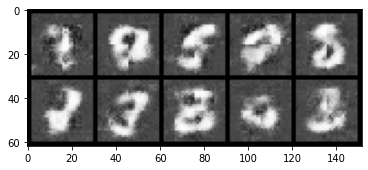

In [43]:
import matplotlib.pyplot as plt
outs = prot_decoder(prototypes.to('cpu')).to('cpu')
grid_img = torchvision.utils.make_grid(outs, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))

In [46]:
print(PrototypeNetwork(prot_nodes=10))

PrototypeNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=10, out_features=10, bias=False)
)


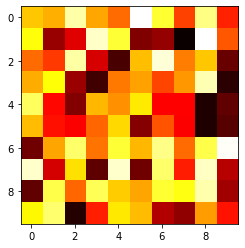

In [44]:
heatmap = model_.PrototypeNetwork.fc.weight.detach()
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.show()

In [45]:
wandb.finish()